# Milestone 3

In [54]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import sqlite3
import csv
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

In [55]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# Increase the default font size
plt.rcParams['font.size'] = 22

## 0: Import Data

In [56]:
conn = sqlite3.connect('../milestone2/FORM13F.db')
cursor = conn.cursor()
df_info = pd.read_sql(f"SELECT * FROM INFOTABLE_2024_Q3;", conn)
df_summary = pd.read_sql(f"SELECT * FROM SUMMARYPAGE_2024_Q3;", conn)
df_cover = pd.read_sql(f"SELECT * FROM COVERPAGE_2024_Q3;", conn)
conn.close()

## 1: Background

## 2: Finalized Research Question

## 3: Data Cleaning and Augmentation

#### Remove rows from `db_info` that report "principal amount"

To keep analysis consistent, we are only looking at rows that report the number of shares.

In [57]:
df_info = df_info[df_info['SSHPRNAMTTYPE'] == 'SH']

#### Merge `df_summary` with `df_cover`

In [58]:
df_investor = df_cover.merge(df_summary, how='inner', on='ACCESSION_NUMBER')

#### Drop two rows whose values appear to be incorrect

For these rows, the number of shares (`SSHPRNAMT`) appears to be reported as an unreasonably high number whereas the `VALUE` appears to be unreasonably row. We will drop these rows. Two rows are negligible in the context of the entire dataset.

In [59]:
df_info = df_info[df_info['ACCESSION_NUMBER'] != '0001104659-24-089646']
df_info = df_info[df_info['ACCESSION_NUMBER'] != '0000894189-24-004736']

#### Ensure datatypes are correct

In [60]:
df_info['SSHPRNAMT'] = df_info['SSHPRNAMT'].astype(float)

#### Compute summary statistics for each institution (`ACCESSION_NUMBER`) in `df_info`.

In [61]:
s = df_info.groupby(by="ACCESSION_NUMBER")['VALUE'].mean()
s = s.rename("MEAN VALUE")
df_stats = s.to_frame()

In [62]:
df_stats['MIN VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].min()
df_stats['MAX VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].max()
df_stats['STD VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].std()
df_stats['25% VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].quantile(q = 0.25)
df_stats['50% VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].median()
df_stats['75% VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].quantile(q = 0.75)
df_stats['10% VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].quantile(q = 0.10)
df_stats['90% VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].quantile(q = 0.90)
df_stats['99% VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].quantile(q = 0.99)
df_stats['01% VALUE'] = df_info.groupby(by='ACCESSION_NUMBER')['VALUE'].quantile(q = 0.01)

In [63]:
df_stats['MEAN SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].mean()
df_stats['MIN SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].min()
df_stats['MAX SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].max()
df_stats['STD SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].std()
df_stats['25% SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].quantile(q = 0.25)
df_stats['50% SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].median()
df_stats['75% SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].quantile(q = 0.75)
df_stats['10% SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].quantile(q = 0.10)
df_stats['90% SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].quantile(q = 0.90)
df_stats['99% SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].quantile(q = 0.99)
df_stats['01% SHAMT'] = df_info.groupby(by='ACCESSION_NUMBER')['SSHPRNAMT'].quantile(q = 0.01)

In [64]:
df_stats = df_stats.reset_index()

#### Add feature for US vs. non-US institutions

In [65]:
state_df = pd.read_csv("../data/state_list.csv")
state_set = set(list(state_df['Abbreviation']))
def UnitedStatesIndicator(x):
    # check if the location is in the US based on the state abbreviation
    return (x in state_set) 
df_investor['US_Indicator'] = df_investor['FILINGMANAGER_STATEORCOUNTRY'].apply(UnitedStatesIndicator)

#### Get full country/state name

In [66]:
# Initialize an empty dictionary
state_dict = {}
# Open the CSV file
with open('../data/state_country_abbreviations.csv', mode='r') as file:
    reader = csv.reader(file,skipinitialspace = True)
    # Iterate through the rows in the file
    for row in reader:
        # Assign the first column as the key and the second column as the value
        state_dict[row[0]] = row[1]
        
def get_country_state(x):
    try: return state_dict[x]
    except KeyError: return np.nan
    
df_investor['State_Country_Full'] = df_investor['FILINGMANAGER_STATEORCOUNTRY'].apply(get_country_state)

#### Import US State GDP data

Additionally, we will add a column that indicates whther the institution is located in the United States.

In [67]:
df_state_gdp = pd.read_csv("../data/state-gdp.csv")
df_state_gdp.columns.values

array(['State', 'Abbreviation', 'Region', '2022_MM', '2023_MM',
       '2023_Q4_Seasonally_Adjusted_MM', '2024_Q1_Seasonall_Adjusted_MM',
       '2024_Q2_Seasonall_Adjusted_MM',
       '2023_Percent_Change_From_Preceding_Period',
       '2024_Q1_Percent_Change_From_Preceding_Period',
       '2024_Q2_Percent_Change_From_Preceding_Period'], dtype=object)

In [68]:
df_ = df_investor['FILINGMANAGER_STATEORCOUNTRY'].value_counts().to_frame().reset_index()
df_

,FILINGMANAGER_STATEORCOUNTRY,count
0,NY,1048
1,CA,887
2,TX,457
3,MA,394
4,FL,364
...,...,...
100,J1,1
101,O1,1
102,O9,1
103,R5,1


In [69]:
df_state_gdp =df_state_gdp.merge(right=df_, how='inner',left_on = 'Abbreviation',right_on='FILINGMANAGER_STATEORCOUNTRY')

In [70]:
df_us = df_investor[df_investor['US_Indicator'] == True]

In [71]:
df_us2 = df_us.merge(
    right=df_state_gdp, 
    how='inner', 
    left_on = 'FILINGMANAGER_STATEORCOUNTRY', 
    right_on='Abbreviation')

#### Merge `df_stats` with `df_us2`

In [72]:
df_us2 = df_us2.merge(right=df_stats, how='inner',on='ACCESSION_NUMBER')

#### Get investor city

In [73]:
df_us2['FILINGMANAGER_CITY'] = df_us2['FILINGMANAGER_CITY'].str.lower()

In [74]:
df_us2['FILINGMANAGER_CITY'].value_counts()

FILINGMANAGER_CITY
new york              824
boston                192
chicago               179
san francisco         157
houston               109
                     ... 
sante fe                1
saint paul              1
indian rocks beach      1
kokomo                  1
kerrville               1
Name: count, Length: 1276, dtype: int64

#### Choose features

In [75]:
features = [
    'TABLEENTRYTOTAL',
    'TABLEVALUETOTAL',
    '2024_Q2_Seasonall_Adjusted_MM',
    '2024_Q2_Percent_Change_From_Preceding_Period',
    'MIN VALUE',
    'MAX VALUE',
    'MEAN VALUE',
    'STD VALUE',
    '25% VALUE',
    '50% VALUE',
    '75% VALUE',
    '01% VALUE',
    '99% VALUE',
    '10% VALUE',
    '90% VALUE',
    'MIN SHAMT',
    'MAX SHAMT',
    'MEAN SHAMT',
    'STD SHAMT',
    '25% SHAMT',
    '50% SHAMT',
    '75% SHAMT',
    '01% SHAMT',
    '99% SHAMT',
    '10% SHAMT',
    '90% SHAMT',
]

In [76]:
def get_log_feature(x):
    try: return np.log(x)
    except RuntimeWarning: return 0

In [77]:
log_features = [
    'LOG TABLEENTRYTOTAL',
    'LOG TABLEVALUETOTAL',
    'LOG 2024_Q2_Seasonall_Adjusted_MM',
    'LOG 2024_Q2_Percent_Change_From_Preceding_Period',
    'LOG MIN VALUE',
    'LOG MAX VALUE',
    'LOG MEAN VALUE',
    'LOG STD VALUE',
    'LOG 25% VALUE',
    'LOG 50% VALUE',
    'LOG 75% VALUE',
    'LOG 01% VALUE',
    'LOG 99% VALUE',
    'LOG 10% VALUE',
    'LOG 90% VALUE',
    'LOG MIN SHAMT',
    'LOG MAX SHAMT',
    'LOG MEAN SHAMT',
    'LOG STD SHAMT',
    'LOG 25% SHAMT',
    'LOG 50% SHAMT',
    'LOG 75% SHAMT',
    'LOG 01% SHAMT',
    'LOG 99% SHAMT',
    'LOG 10% SHAMT',
    'LOG 90% SHAMT',
]

In [78]:
for i, log_feature in enumerate(log_features):
    df_us2[log_feature] = df_us2[features[i]].apply(get_log_feature)
feature_list = log_features
feature_list.append('OTHERINCLUDEDMANAGERSCOUNT')
df_starlog = df_us2[log_features]
df_star = df_us2[features]
df_star.to_csv("../data/df_star.csv")
# feature_list

## 4: Data Visualization and Insights

#### Average value of securities held by institution

Each institutional investor holds a porfolio of securities that are reported on Form 13F. Each security is held in given quantity at a given value. We can compute the average value of securities held by each institution. Note that on Form 13F, the total value of the securities is reported, not the price of one share.

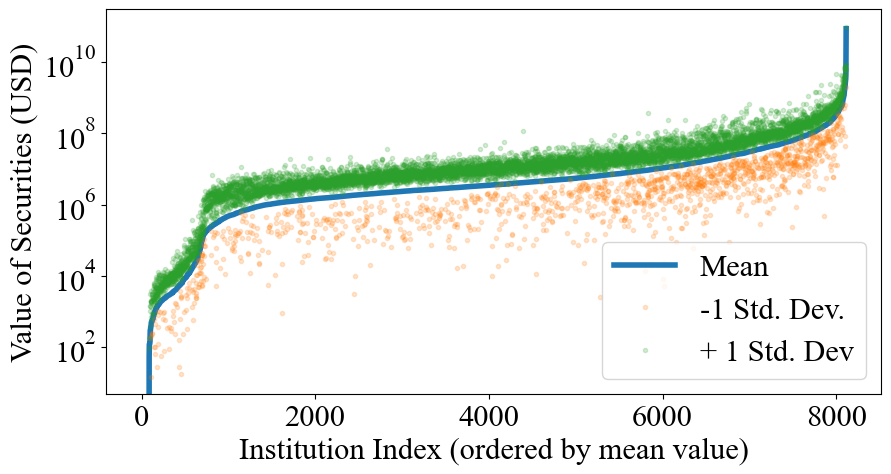

In [81]:
df_stats_sorted = df_stats.sort_values(by="MEAN VALUE")
x = np.arange(len(df_stats_sorted))
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(x, df_stats_sorted['MEAN VALUE'], label='Mean',linewidth=4)
ax.plot(x, df_stats_sorted['MEAN VALUE'] - df_stats_sorted['STD VALUE'],'.', alpha=0.2,label='-1 Std. Dev.')
ax.plot(x, df_stats_sorted['MEAN VALUE'] + df_stats_sorted['STD VALUE'],'.', alpha=0.2, label='+ 1 Std. Dev')
ax.set_ylabel("Value of Securities (USD)")
ax.legend()
ax.set_xlabel("Institution Index (ordered by mean value)")
ax.set_yscale("log")

#### State GDP vs. Number of Investors per State

Here, each data point represents an indvidual state. States with higher GDPs have more investors. This is not surprising as states with higher GDPs have more economic activity and thus more investors.

Text(0.5, 1.0, 'State GDP vs. Number of Investors From Each State')

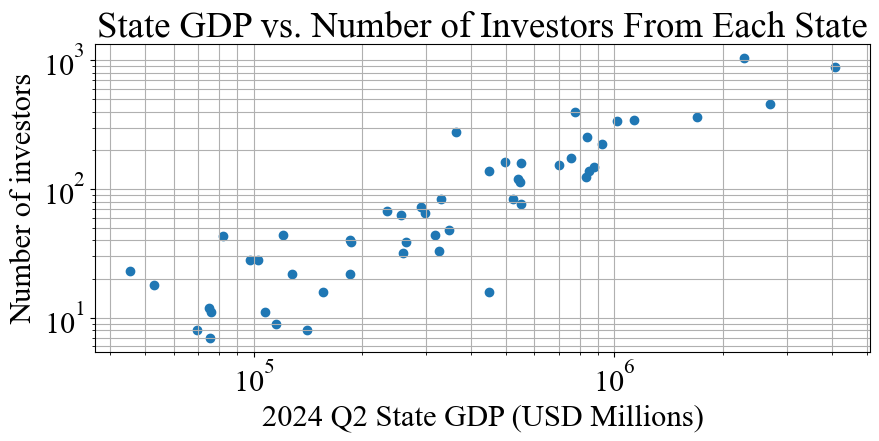

In [89]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.scatter(df_state_gdp['2024_Q2_Seasonall_Adjusted_MM'], df_state_gdp['count'])
ax.set_xscale('log')
ax.set_xlabel("2024 Q2 State GDP (USD Millions)")
ax.set_ylabel("Number of investors")
ax.grid(True,which='both')
ax.set_yscale('log')
ax.set_title("State GDP vs. Number of Investors From Each State")

### Numerical Correlations with `TOTAL_VALUE`

#### Correlating `TOTAL_VALUE` with the summary statistics of the `VALUE` column in `df_info`.

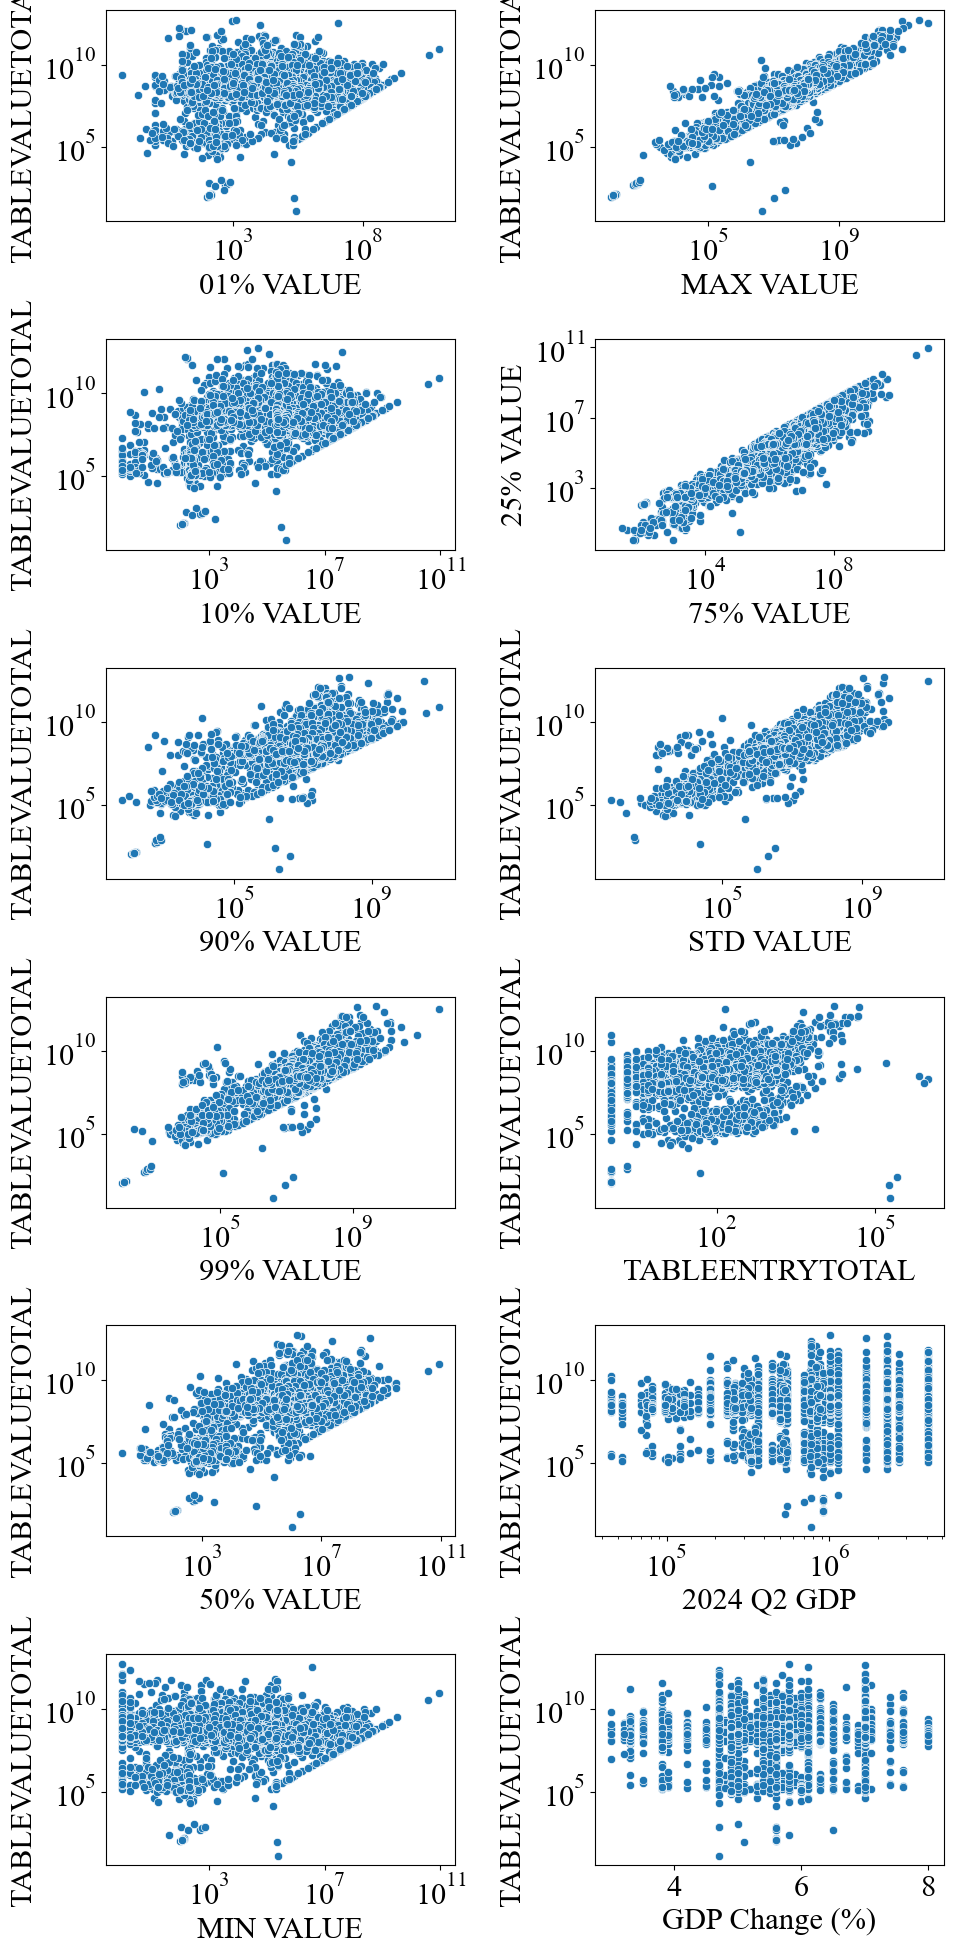

In [114]:
# fig, ax = plt.subplots(1,1,figsize=(6,3))
fig, ax = plt.subplots(6,2,figsize=(10,20))
# a1 = ax[0,0]
# a2 = ax[0,1]
# a3 = ax[0,2]

# a4 = ax[1,0]
# a5 = ax[1,1]
# a6 = ax[1,2]

# a7 = ax[2,0]
# a8 = ax[2,1]
# a9 = ax[2,2]

# a10 = ax[3,0]
# a11 = ax[3,1]
# a12 = ax[3,2]

a1 = ax[0,0]
a2 = ax[1,0]
a3 = ax[2,0]

a4 = ax[3,0]
a5 = ax[4,0]
a6 = ax[5,0]

a7 = ax[0,1]
a8 = ax[1,1]
a9 = ax[2,1]

a10 = ax[3,1]
a11 = ax[4,1]
a12 = ax[5,1]

# a1 = ax
sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '01% VALUE', ax = a1)
a1.set_xscale("log"), a1.set_yscale("log")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '10% VALUE', ax = a2)
a2.set_xscale("log"), a2.set_yscale("log")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '90% VALUE', ax = a3)
a3.set_xscale("log"), a3.set_yscale("log")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '99% VALUE', ax = a4)
a4.set_xscale("log"), a4.set_yscale("log")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '50% VALUE', ax = a5)
a5.set_xscale("log"), a5.set_yscale("log")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = 'MIN VALUE', ax = a6)
a6.set_xscale("log"), a6.set_yscale("log")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = 'MAX VALUE', ax = a7)
a7.set_xscale("log"), a7.set_yscale("log")

sns.scatterplot(data = df_star, y = '25% VALUE', x = '75% VALUE', ax = a8)
a8.set_xscale("log"), a8.set_yscale("log")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = 'STD VALUE', ax = a9)
a9.set_xscale("log"), a9.set_yscale("log")

sns.scatterplot(data = df_star, x = 'TABLEENTRYTOTAL', y = 'TABLEVALUETOTAL', ax = a10)
a10.set_xscale("log"), a10.set_yscale("log")

sns.scatterplot(data = df_star, x = '2024_Q2_Seasonall_Adjusted_MM', y = 'TABLEVALUETOTAL', ax = a11)
a11.set_xscale("log"), a11.set_yscale("log")
a11.set_xlabel("2024 Q2 GDP")

sns.scatterplot(data = df_star, x = '2024_Q2_Percent_Change_From_Preceding_Period', y = 'TABLEVALUETOTAL', ax = a12)
a12.set_xlabel("GDP Change (%)")
# ax.set_xscale("log")
a12.set_yscale("log")
plt.tight_layout()
plt.show()


#### Correlating `TOTAL_VALUE` with the summary statistics of the `SSHPRNAMT` column in `df_info`.

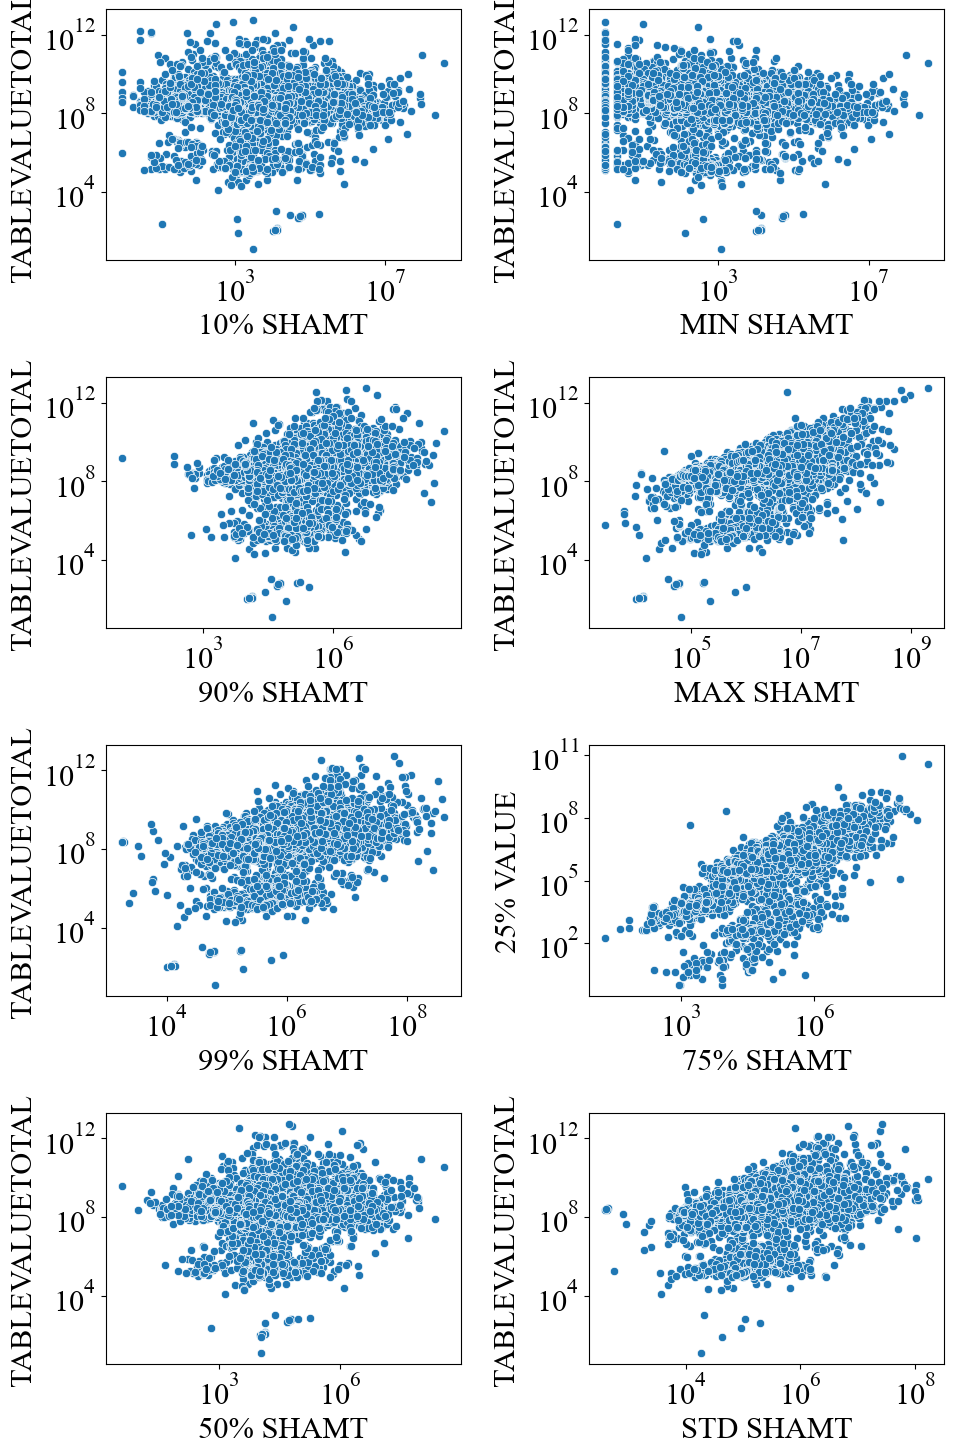

In [121]:
# fig, ax = plt.subplots(1,1,figsize=(6,3))
fig, ax = plt.subplots(4,2,figsize=(10,15))
# a1 = ax[0,0]
# a2 = ax[0,1]
# a3 = ax[0,2]

# a4 = ax[1,0]
# a5 = ax[1,1]
# a6 = ax[1,2]

# a7 = ax[2,0]
# a8 = ax[2,1]
# a9 = ax[2,2]

# a1 = ax[0,1]
a2 = ax[0,0]
a3 = ax[1,0]
a4 = ax[2,0]
a5 = ax[3,0]

a6 = ax[0,1]
a7 = ax[1,1]
a8 = ax[2,1]
a9 = ax[3,1]



# a1 = ax
# sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '01% SHAMT', ax = a1)
# a1.set_xscale("log"), a1.set_yscale("log")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '10% SHAMT', ax = a2)
a2.set_xscale("log"), a2.set_yscale("log")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '90% SHAMT', ax = a3)
a3.set_xscale("log"), a3.set_yscale("log")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '99% SHAMT', ax = a4)
a4.set_xscale("log"), a4.set_yscale("log")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = '50% SHAMT', ax = a5)
a5.set_xscale("log"), a5.set_yscale("log")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = 'MIN SHAMT', ax = a6)
a6.set_xscale("log"), a6.set_yscale("log")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = 'MAX SHAMT', ax = a7)
a7.set_xscale("log"), a7.set_yscale("log")

sns.scatterplot(data = df_star, y = '25% VALUE', x = '75% SHAMT', ax = a8)
a8.set_xscale("log"), a8.set_yscale("log")

sns.scatterplot(data = df_star, y = 'TABLEVALUETOTAL', x = 'STD SHAMT', ax = a9)
a9.set_xscale("log"), a9.set_yscale("log")

plt.tight_layout()
plt.show()

#### Heatmap of correlations with logathmically transformed features.

In [122]:
df_starlog

,LOG TABLEENTRYTOTAL,LOG TABLEVALUETOTAL,LOG 2024_Q2_Seasonall_Adjusted_MM,LOG 2024_Q2_Percent_Change_From_Preceding_Period,LOG MIN VALUE,LOG MAX VALUE,LOG MEAN VALUE,LOG STD VALUE,LOG 25% VALUE,LOG 50% VALUE,...,LOG MEAN SHAMT,LOG STD SHAMT,LOG 25% SHAMT,LOG 50% SHAMT,LOG 75% SHAMT,LOG 01% SHAMT,LOG 99% SHAMT,LOG 10% SHAMT,LOG 90% SHAMT,OTHERINCLUDEDMANAGERSCOUNT
0,5.087596,19.011690,15.221651,1.686399,10.839757,16.053859,13.924094,14.253237,12.744613,13.169647,...,9.804426,10.327945,8.020024,8.995723,9.920922,6.273198,11.801193,7.185160,10.514785,0
1,5.389072,19.226115,13.735142,1.722767,4.174387,16.373494,13.837044,14.221460,9.730294,13.434983,...,9.702978,10.479292,6.134482,8.209036,9.618901,2.217027,12.163329,3.577948,10.621791,0
2,4.912655,18.789060,15.221651,1.686399,0.000000,17.818521,13.876405,15.440341,9.252178,10.925282,...,8.748064,9.694553,5.020586,6.396930,8.171953,1.740466,11.280599,3.713572,9.662116,0
3,2.639057,19.566200,13.217988,1.757858,14.237669,17.804994,16.927143,16.712882,15.052688,16.988091,...,13.458836,13.943712,12.611538,12.729321,13.122363,10.183011,15.224178,12.095141,13.933294,0
4,4.927254,18.878571,15.221651,1.686399,0.000000,17.867387,13.951317,15.508026,9.231294,10.822963,...,8.931397,10.058834,5.068904,6.332391,8.046309,1.747459,11.608890,3.843744,9.546055,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7046,2.833213,18.802778,13.832620,1.757858,11.128542,17.816835,15.969565,16.626060,13.377663,14.709798,...,13.746338,14.555338,10.149097,11.884758,13.123944,8.875360,15.841736,10.006910,14.636564,0
7047,3.258097,19.310607,13.832620,1.757858,10.270558,18.293014,16.052510,16.842452,13.433819,14.532378,...,13.381527,14.360504,10.309985,11.663606,12.596436,8.802335,15.778571,9.237518,13.982339,0
7048,3.433987,18.995486,13.832620,1.757858,10.203407,17.753321,15.561498,16.279042,13.764446,14.392405,...,13.297660,14.279301,10.414333,11.278418,12.583174,8.790847,15.741675,10.015476,13.880835,0
7049,3.044522,12.073021,13.117614,1.335001,2.890372,10.343290,9.028499,9.190902,4.564348,8.716863,...,12.144435,12.406478,7.047517,11.244091,12.377889,5.139322,13.640419,6.336826,13.033783,0


In [130]:
df_starlog1 = df_starlog[[
    'LOG TABLEVALUETOTAL',
    'LOG MIN SHAMT',
    'LOG MAX SHAMT',
    'LOG MEAN SHAMT',
    'LOG STD SHAMT',
    'LOG 25% SHAMT',
    'LOG 50% SHAMT',
    'LOG 75% SHAMT',
    'LOG 01% SHAMT',
    'LOG 99% SHAMT',
    'LOG 10% SHAMT',
    'LOG 90% SHAMT']]

df_starlog2 = df_starlog[[
    'LOG TABLEVALUETOTAL',
    'LOG MIN VALUE',
    'LOG MAX VALUE',
    'LOG MEAN VALUE',
    'LOG STD VALUE',
    'LOG 25% VALUE',
    'LOG 50% VALUE',
    'LOG 75% VALUE',
    'LOG 01% VALUE',
    'LOG 99% VALUE',
    'LOG 10% VALUE',
    'LOG 90% VALUE',
]]


In [131]:
corr =  df_starlog2.corr()

<Axes: >

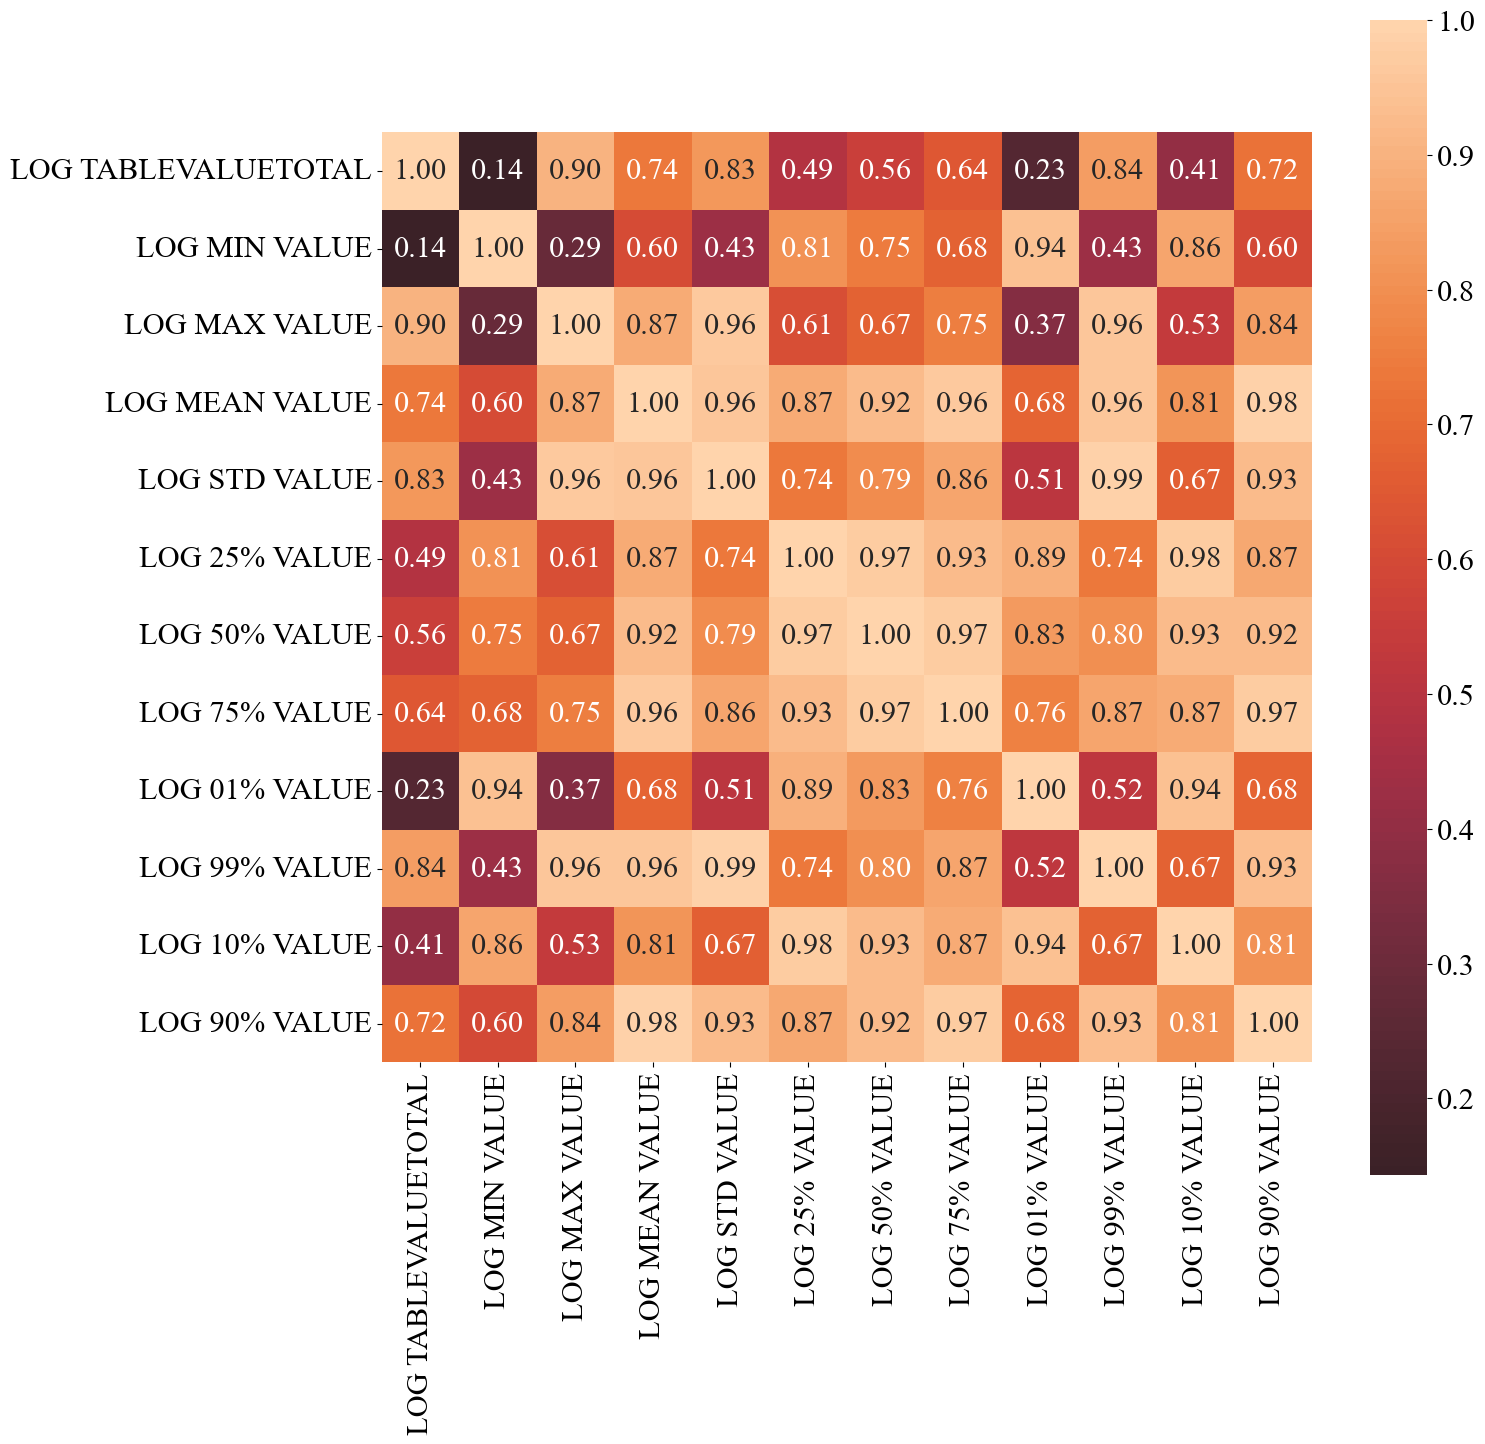

In [132]:

plt.figure(figsize=(15, 15))
sns.heatmap(corr, center=0, annot=True,fmt='.2f', square=True)